# Modelling external isolation

In this notebook we use an age- and household-structured model to assess the impact of external quarantining as a mitigation measure against covid-19. We compare against the more typical internal quarantine approach. Under external quarantining, a single infected individual is removed from the household and has no interaction with the members of that household or any other. Under internal quarantining, the infected individual is still able to interact with the other members of their household but the entire household is completely prevented from contributing to the population-level outbreak.

The following cell imports all of the dependencies required for this notebook.

In [1]:
from os import getcwd, chdir
from os.path import isfile
from pickle import load, dump
from numpy import arange, array
from numpy.random import rand
from pandas import read_csv
from time import time as get_time
from scipy.integrate import solve_ivp
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from model.preprocessing import TwoAgeWithVulnerableInput, HouseholdPopulation
from model.preprocessing import add_vulnerable_hh_members, make_initial_SEPIRQ_condition
from model.common import SEPIRQRateEquations, within_household_SEPIRQ
from model.imports import ( FixedImportModel)

The working directory needs to be the main repo directory, `...\GitHub\covid-19-in-households-public`. If the kernel is clear, the following cell will set this to be the working directory. Once you have run this cell, do not run it again without clearing the kernel.

In [2]:
print(getcwd())
chdir('..\..')
print(getcwd())

C:\Users\Joe Hilton\Documents\GitHub\covid-19-in-households-public\examples\external_isolation
C:\Users\Joe Hilton\Documents\GitHub\covid-19-in-households-public


## Model description

We use a compartmental model with six compartments, **S**usceptible, **E**xposed, **P**rodromal/presymptomatic infection, symptomatic/fully transmissible **I**nfection, **R**ecovered, and **Q**uarantined/isolated, which we will call the SEPIRQ model. The same structure is used under both external and internal quarantining, but the impact of the **Q** compartment is different depending on the quarantining method being used. The possible transitions are infection of a susceptible (**S** to **E**), progression from exposure into the prodromal phase (**E** to **P**), progression from prodrome into full infection (**P** to **I**), recovery of an infectious cases (**I** to **R**), quarantining of infected cases (**E**, **P**, and **I** to **Q**), and recovery of a quarantined case (**Q** to **R**). The population is further subdivided into three age- and vulnerability-stratified classes: children, non-vulnerable adults, and vulnerable adults. Our model works at the level of a single household, which is specified by the number of individuals of each class in the household. These numbers are static, but the members of each class may move between epidemic compartments. The instantaneous state of a household can be summarised as
$$
(S_C,E_C,P_C,I_C,R_C,Q_C,S_A,E_A,P_A,I_A,R_A,Q_A,S_V,E_V,P_V,I_V,R_V,Q_V).
$$
The dynamics within each household are captured by a Markov chain whose evolution is captured by a set of Kolmogorov equations. The equations corresponding to households in different compositions can be combined into a block-diagonal system, with the proportion of households in a given composition equal to the total probability in the corresponding block. Because infection can transmit between households, we add a nonlinear term to the Kolmogorov equations capturing household-to-household transmission which couples the otherwise independent blocks of the system.

In the following cell we introduce the disease parameters for our model. The three "progression" events (**E** to **P**, **P** to **I**, and **I** to **R**) take place at fixed per-capita rates $\alpha_1$, $\alpha_2$, and $\gamma$. Here we choose rates of 1/1, 1/5, 1/4, i.e. each case experiences on average a short incubation period of one day, four days of prodromal infection and five days of full/symptomatic infection before recovering. Infection occurs along three different routes: internal transmission between members of the same household, external transmission between members of different households, and imports of infection from outside of the population. Both prodromal and symptomatic individuals transmit, with the infectiousness of prodromal individuals scaled by an age-specific factor $\tau$. The intensity of between-household transmission is scaled down by a factor $\epsilon$, capturing the idea that interactions outside the household are likely to involve less intensive contact than those within the household; since this is the only interaction between households, $\epsilon$ defines the level of coupling between the different household sub-systems. The transmission is age-structured through the use of age-structured contact matrices $\mathbf{K}_{\mathrm{home}}$ and $\mathbf{K}_{\mathrm{ext}}$ and an age-specific susceptibility vector $\mathbf{\sigma}$ (`sus` in the cell below). To obtain age-structured transmission matrices for within- and between-household transmission we scale the rows of the two contact matrices by the elements of $\mathbf{\sigma}$ and then mutliply both (with the external mixing term scaled by $\epsilon$) by a scaling factor chosen such that the eigenvalue of the sum of the two transmission matrices is equal to a specified basic reproductive ratio.

These parameters are specified in a dictionary in the next block. The contact matrices are taken from estimates generated by Prem et. al. (2017). Because we will be using different age boundaries to them, we need to aggregate their estimated matrices, which requires an estimate of the sizes of each age class in their division, which we take from the file `United Kingom-2019.csv`. We also need to then split the adults into vulnerable and nonvulnerable individuals - to do this we need the population-level proportion of individuals who are vulnerable.

In [3]:
SEPIRQ_SPEC = {
    # Interpretable parameters:
    'R0': 2.4,                      # Reproduction number
    'gamma': 1/4,                   # Recovery rate
    'alpha_1': 1/1,                   # E->P incubation rate
    'alpha_2': 1/5,                   # P->I prodromal to symptomatic rate
    'tau': array([0.5,0.5,0.5]),           # Prodromal transmission intensity relative to full inf transmission
    'sus': array([1,1,1]),                 # Relative susceptibility by age/vulnerability class
    'epsilon': 0.5,                  # Relative intensity of external compared to internal contacts
    'vuln_prop': 2.2/60,            # Total proportion of adults who are shielding
    'k_home': {
        'file_name': 'inputs/MUestimates_home_2.xlsx',
        'sheet_name':'United Kingdom of Great Britain'
    },
    'k_all': {
        'file_name': 'inputs/MUestimates_all_locations_2.xlsx',
        'sheet_name': 'United Kingdom of Great Britain'
    },
    'pop_pyramid_file_name': 'inputs/United Kingdom-2019.csv'
}

## Introducing quarantine

In the cell below we convert the specifications from the dictionary into input for our model and add some extra parameters which define the quarantining strategy we wish to model. The rate at which an infected individual is quarantined depends on how far the infection has progressed; isolation should happen faster as the infection progresses because more advanced cases should be easier to identify and simply because these cases will have had more time to be found through tracing. We define a discharge rate of 14 days, which should be long enough for individuals to be recovered when they return home or cease isolating. The parameter `model_input.adult_bd` defines the boundary between children and adults in the list of age classes (using zero-indexing). In our simple two-age-class-plus-vulnerable-adults framework this is just 1, but for flexibility we keep it a user-defined parameter. Specifying this boundary is necessary because when implementing external isolation we do not allow adults to isolate if it means leaving children alone without any adults. The Boolean array `model_input.class_is_isolating` captures the answer to the question "if a person of class $j$ is present in the household, should a case of class $i$ isolate?". For external isolation, we are interested in isolating adults who live with vulnerable adults, so the $(2,3)$rd and $(3,3)$rd entries of the matrix is `True`, and everything else is false. The last parameter, `model_input.iso_method`, is set to 0 if we are modelling external isolation and 1 if we are modelling internal isolation.

We will start by modelling external isolation. Under this control strategy, when an individual enters the quarantine compartment it makes no contribution to within- or between-household infectious pressures. Because we model within-household mixing as frequency dependent, the rate of infection within households includes a factor of $1/(S+E+P+I+R)$ which does *not* include the quarantined individuals. When externally quarantined individuals are discharged they join the recovered compartment and behave identically to the other members of this compartment.

Internal isolation is slightly more complex. When an individual is quarantined, they remain in the household (in particular, the household size remains $(S+E+P+I+R+Q)$) and continue to transmit infection to other members of their household. We scale their infectiousness relative to cases in the **I** compartment by a factor $(\frac{1}{\alpha_2}\tau + \frac{1}{\gamma})/(\frac{1}{\alpha_1} + \frac{1}{\alpha_2} + \frac{1}{\gamma})$. This slightly unwieldy expression averages over the possible relative infectiousness of this quarantined case - zero if exposed, $\tau$ if prodromal, one if fully infectious. The purpose of internal isolation is to reduce household-to-household transmission, which we account for by scaling the contribution of all households containing one or more quarantined cases to population-level infectiousness by the factor `model_input.isoprob`.

In [4]:
spec = SEPIRQ_SPEC
model_input = TwoAgeWithVulnerableInput(SEPIRQ_SPEC)

model_input.E_iso_rate = 1/1
model_input.P_iso_rate = 1/1
model_input.I_iso_rate = 1/0.5
model_input.discharge_rate = 1/14
model_input.adult_bd = 1
model_input.class_is_isolating = array([[False, False, False],[False, False, True],[False, False, True]])
model_input.iso_method = 0
model_input.iso_prob = 0.5

## Building the household population

Next we construct household population object which captures all the within-household events - everything except external imports of infection. We do this by reading in a preprepared list of possible compositions in terms of the number of children, non-vulnerable adults, and vulnerable adults in a household, and an accompanying list which estimates the proportion of households in each composition. We combine this information with our model input to create a household population object. The last two arguments in `HouseholdPopulation` specify the compartmental structure and number of compartments.

In [5]:
# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_vuln_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_vuln_composition_dist.csv',
    header=0).to_numpy().squeeze()
# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input, within_household_SEPIRQ,6)

Building within-household transmission matrix: 100%|███████████████████████████████████| 81/81 [00:35<00:00,  2.30it/s]


## Solving the ODE system

In the next cell we solve the system of ODEs defining the evolution of our household population. We begin by specifying the model we are using for external imports of infection. In this example we choose a fixed per-capita rate of importation, but our code also allows for time-varying imports. We specify the rates of importation for prodromal and fully symptomatic infections separately, emphasising that the requisite scaling of prodromal infection by $\tau$ takes place within the code so does not need to be applied here; we specify separate rates to account for the possibility that fully infectious cases may be less likely to travel than prodromal cases.

The right-hand-side object `rhs` defines the system of ODEs. The initial condition we generate places a single infectious case into 0.1% of all households - this is the final element of `make_initital_SEPIRQ_condition`. We then solve the equations using `solve_ivp`. Notice that we need to set a very low absolute tolerance, because numerical errors can cause the system to move into negative probability space.

In [6]:
import_model = FixedImportModel(
    1e-5, # Import rate of prodromals
    1e-5) # Import rate of symptomatic cases

rhs = SEPIRQRateEquations(
    model_input,
    household_population,
    import_model)

H0 = make_initial_SEPIRQ_condition(household_population, rhs, 1e-3)

no_days = 50
tspan = (0.0, no_days)
solver_start = get_time()
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)
solver_end = get_time()

print('Integration completed in', solver_end-solver_start,'seconds.')

time = solution.t
H = solution.y

Integration completed in 111.00854754447937 seconds.


In the cell below we calculate the expected size of each compartment (stratified by age/vulnerability class) over time. We also calculate the average number of children, non-vulnerable adults, and vulnerable adults per household, which we use to estimate things like prevalence stratified by class.

In [7]:
S = H.T.dot(household_population.states[:, ::6])
E = H.T.dot(household_population.states[:, 1::6])
P = H.T.dot(household_population.states[:, 2::6])
I = H.T.dot(household_population.states[:, 3::6])
R = H.T.dot(household_population.states[:, 4::6])
Q = H.T.dot(household_population.states[:, 5::6])

children_per_hh = comp_dist.T.dot(composition_list[:,0])
nonv_adults_per_hh = comp_dist.T.dot(composition_list[:,1])
vuln_adults_per_hh = comp_dist.T.dot(composition_list[:,2])

We now plot the expected prevalence over time in each age-vulnerability class, and the proportion of each class in quarantine.

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


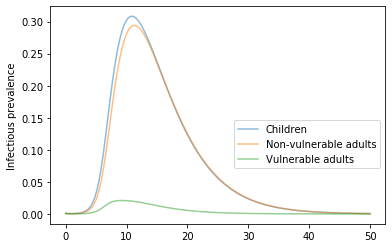

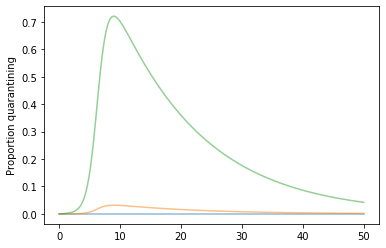

In [8]:
class_per_hh = [children_per_hh, nonv_adults_per_hh, vuln_adults_per_hh]

lgd=['Children','Non-vulnerable adults','Vulnerable adults']

fig1, axis1 = subplots()
fig2, axis2 = subplots()
cmap = get_cmap('tab20')
alpha = 0.5
for i in range(3):
    axis1.plot(
        time, I[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i*2), alpha=alpha)
    axis2.plot(
        time, Q[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i*2), alpha=alpha)
axis1.set_ylabel('Infectious prevalence')
axis2.set_ylabel('Proportion quarantining')

axis1.legend(ncol=1, bbox_to_anchor=(1,0.50))

fig1.show()
fig2.show()


## Modelling internal quarantine

Under internal quarantine, a household is designated as quarantined as soon as one of the members of that household enters the **Q** compartment. The internal dynamics of the household are essentially unaffected, but when we calculate population-level force of infection we scale down the contributions of all quarantined household by a chosen factor (the variable `model_input.iso_prob`, which we earlier set to 0.5). Since the aim of internal quarantine is to prevent infection from leaving the household, rather than preventing within-household spread to vulnerable people, we set all of the Boolean isolation indicators to `True`. We reconstruct the household population and ODE system with our new model input, and solve once again.

In [9]:
model_input.class_is_isolating = array([[True, True, True],[True, True, True],[True, True, True]])
model_input.iso_method = 1

household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input, within_household_SEPIRQ,6)

rhs = SEPIRQRateEquations(
    model_input,
    household_population,
    import_model)

H0 = make_initial_SEPIRQ_condition(household_population, rhs, 1e-3)

tspan = (0.0, no_days)
solver_start = get_time()
solution = solve_ivp(rhs, tspan, H0, first_step=0.001,atol=1e-16)
solver_end = get_time()

print('Integration completed in', solver_end-solver_start,'seconds.')

time = solution.t
H = solution.y

Building within-household transmission matrix: 100%|███████████████████████████████████| 81/81 [00:41<00:00,  1.94it/s]


Integration completed in 182.70865082740784 seconds.


In the cell below we calculate the expected number of people of each age-vulnerability class in each compartment in a single household over time. Because we are more interested in the number of people who are self-isolating rather than the number who are actually in the **Q** compartment, we define `Q`, the number of people per household quarantining over time to be the expected number of people in a household with at least one person in the **Q** compartment.

In [10]:
S = H.T.dot(household_population.states[:, ::6])
E = H.T.dot(household_population.states[:, 1::6])
P = H.T.dot(household_population.states[:, 2::6])
I = H.T.dot(household_population.states[:, 3::6])
R = H.T.dot(household_population.states[:, 4::6])
states_iso_only = household_population.states[:,5::6]
total_iso_by_state =states_iso_only.sum(axis=1)
iso_present = total_iso_by_state>0
Q = H[iso_present,:].T.dot(household_population.composition_by_state[iso_present,:])

We again plot the expected prevalence and proportion of each age class in quarantine over time:

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


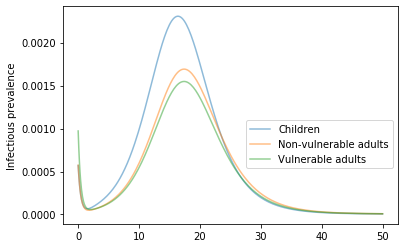

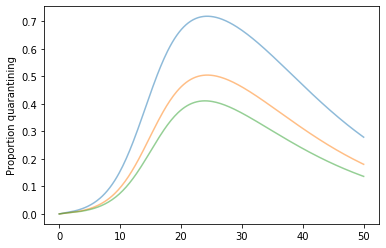

In [11]:
class_per_hh = [children_per_hh, nonv_adults_per_hh, vuln_adults_per_hh]

lgd=['Children','Non-vulnerable adults','Vulnerable adults']

fig1, axis1 = subplots()
fig2, axis2 = subplots()
cmap = get_cmap('tab20')
alpha = 0.5
for i in range(3):
    axis1.plot(
        time, I[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i*2), alpha=alpha)
    axis2.plot(
        time, Q[:,i]/class_per_hh[i], label=lgd[i],
        color=cmap(i*2), alpha=alpha)
axis1.set_ylabel('Infectious prevalence')
axis2.set_ylabel('Proportion quarantining')

axis1.legend(ncol=1, bbox_to_anchor=(1,0.50))

fig1.show()
fig2.show()
